# Image Retrieval
Progetto dalle immagini di pokemon a riconoscimento di animali

In [71]:
from matplotlib import pyplot as plt
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications import mobilenet_v2, ResNet50, resnet50
keras.__version__

'2.4.0'

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
import zipfile, os
# this would take very long !!!
base_dir = '/content/drive/MyDrive/Magistrale/II anno/Image signal/DSIM_project/image retrieval'
zip = zipfile.ZipFile(f'{base_dir}/AwA2-data.zip')
zip.extractall()
zip.close()

### Import reti 

In [74]:
my_resnet50 = ResNet50(include_top = False, weights='imagenet',
                       pooling = 'max', input_shape=(224,224,3))

In [75]:
# tagliamo la rete al livello flatten
my_mobilenet_v2 = mobilenet_v2.MobileNetV2(include_top=False, weights = 'imagenet', 
                               pooling = 'max', input_shape=(224, 224, 3))

### Funzioni per caricare il dataset di immagini di base

In [76]:
def mobilenet_v2_features(img, net):
    '''
      Takes an image in order to extract the features of mobilenet_v2
      @params:
        - img: image to compute
        - net: neural network to use
    '''
    x = kimage.img_to_array(img) # to numpy
    x = mobilenet_v2.preprocess_input(x) # preprocess for network
    x = np.expand_dims(x, axis=0) # necessario per la rete
    features = net.predict(x).flatten()
    return features

In [77]:
def resnet50_features(img, net):
    '''
      Takes an image in order to extract the features of mobilenet_v2
      @params:
        - img: image to compute
        - net: neural network to use
    '''
    x = kimage.img_to_array(img) # to numpy
    x = resnet50.preprocess_input(x) # preprocess for network
    x = np.expand_dims(x, axis=0) # necessario per la rete
    features = net.predict(x).flatten()
    return features

In [78]:
# Limit number of loaded images
maximg_class = 200 # 30 img per ogni classe
#maximages = 500
classes = ["buffalo", "moose", "deer", "horse", "weasel", "sheep", "chimpanzee",
           "lion", "raccoon", "fox"]

# Dummy feature - esempio giocattolo
#def identity(image):
#    return kimage.img_to_array(img).flatten()

# Data loader
def load_data(base_path, net, feature_extractor=mobilenet_v2_features):
    '''
      Load image database features by applying feature extraction of a neural network
      @params:
        - base_path: path where folders of classes of images are stored
        - feature_extractor: function that extracts features on a image
        - preprocess_fuction: function to apply to image in order to insert it 
              in the neural network
        - net: neural network to apply
    '''
    paths = []
    features = []

    for fold in classes:
      cur_fold = base_path + fold + '/'
      for file_n, f in enumerate(sorted(os.listdir(cur_fold))):
        if f.endswith('.jpg'):
          # Save file path
          cur_path = cur_fold + f
          paths.append(cur_path)
          
          # Load file and extract features
          image = kimage.load_img(cur_path, target_size=(224, 224, 3))
          cur_features = feature_extractor(image, net)
          features.append(cur_features)
          
        if (file_n > maximg_class) :
          break
          
      print(f"{fold} DONE")

    features = np.array(features)
    return features, paths

### Load images

In [79]:
# carico img di base + paths
jpg_path = f"/content/Animals_with_Attributes2/JPEGImages/"
X_train, paths = load_data(jpg_path, feature_extractor=resnet50_features, net = my_resnet50)
X_train.shape

buffalo DONE
moose DONE
deer DONE
horse DONE
weasel DONE
sheep DONE
chimpanzee DONE
lion DONE
raccoon DONE
fox DONE


(2020, 2048)

Usiamo un KDTree per suddividere lo spazio di ricerca (**ALTRI????**)

In [80]:
from sklearn.neighbors import KDTree
tree = KDTree(X_train)

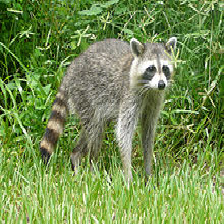

In [81]:
# carico immagine di query + estraggo le sue features
query_image = kimage.load_img(f'{base_dir}/images_animals_test/raccoon_2.jpg', target_size=(224, 224, 3))
query_features = resnet50_features(query_image, my_resnet50)
query_features = np.expand_dims(query_features, axis = 0)
#plot image
query_image

In [82]:
# ricerca nello spazio 
dist, ind = tree.query(query_features, k=10)
# dist > distanza rispetto l'immagine di query
# ind > indice dell'immagine trovata

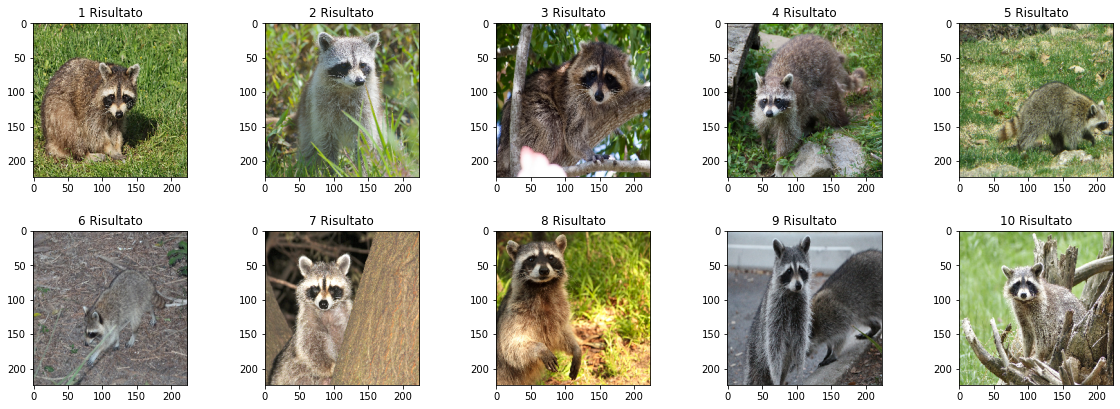

In [83]:
fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize=(10,7))
for j in range(2):
  for i in range(5):
    im = kimage.load_img(paths[ind[0][i+j*5]], target_size=(224,224,3))
    axs[j][i].imshow(im)
    axs[j][i].set_title(f"{5*j+i+1} Risultato")
plt.subplots_adjust(left = 0.2, right= 1.7, wspace = 0.5)
